In [1]:
import collections
import json
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from mab import algs


class ONN(nn.Module):
    def __init__(self, features_size, max_num_hidden_layers, qtd_neuron_per_hidden_layer, n_classes, batch_size=1,
                 b=0.99, n=0.01, s=0.2, use_cuda=False):
        super(ONN, self).__init__()

        if torch.cuda.is_available() and use_cuda:
            print("Using CUDA :]")

        self.device = torch.device(
            "cuda:0" if torch.cuda.is_available() and use_cuda else "cpu")

        self.features_size = features_size
        self.max_num_hidden_layers = max_num_hidden_layers
        self.qtd_neuron_per_hidden_layer = qtd_neuron_per_hidden_layer
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.b = Parameter(torch.tensor(
            b), requires_grad=False).to(self.device)
        self.n = Parameter(torch.tensor(
            n), requires_grad=False).to(self.device)
        self.s = Parameter(torch.tensor(
            s), requires_grad=False).to(self.device)

        self.hidden_layers = []
        self.output_layers = []

        self.hidden_layers.append(
            nn.Linear(features_size, qtd_neuron_per_hidden_layer))

        for i in range(max_num_hidden_layers - 1):
            self.hidden_layers.append(
                nn.Linear(qtd_neuron_per_hidden_layer, qtd_neuron_per_hidden_layer))

        for i in range(max_num_hidden_layers):
            self.output_layers.append(
                nn.Linear(qtd_neuron_per_hidden_layer, n_classes))

        self.hidden_layers = nn.ModuleList(self.hidden_layers).to(self.device)
        self.output_layers = nn.ModuleList(self.output_layers).to(self.device)

        self.alpha = Parameter(torch.Tensor(self.max_num_hidden_layers).fill_(1 / (self.max_num_hidden_layers + 1)),
                               requires_grad=False).to(
            self.device)

        self.loss_array = []
        self.tp=0.1
        self.tn=0.1
        self.fp=0.1
        self.fn=0.1
        self.bal_acc = 0
        self.sen = 0
        self.spec = 0
        
        self.protected_pos = 0.1
        self.protected_neg = 0.1
        self.non_protected_pos = 0.1
        self.non_protected_neg = 0.1
        self.stp_score=0
        
        self.tp_protected = 0.1
        self.fn_protected = 0.1
        self.tp_non_protected = 0.1
        self.fn_non_protected = 0.1
        self.eqop_score=0

    def zero_grad(self):
        for i in range(self.max_num_hidden_layers):
            self.output_layers[i].weight.grad.data.fill_(0)
            self.output_layers[i].bias.grad.data.fill_(0)
            self.hidden_layers[i].weight.grad.data.fill_(0)
            self.hidden_layers[i].bias.grad.data.fill_(0)

    def update_weights(self, X, Y, weight, show_loss):
        Y = torch.from_numpy(Y).to(self.device)
        prediction_1 = self.predict_1(X)
        predictions_per_layer = self.forward(X)
        
        
        self.update_eval_metrics(prediction_1,Y)
        self.update_stp_score(prediction_1,X)
        self.update_eqop_score(prediction_1,X,Y)
        
        losses_per_layer = []

        for out in predictions_per_layer:
            criterion = nn.CrossEntropyLoss().to(self.device)
            loss = criterion(out.view(self.batch_size, self.n_classes), Y.view(
                self.batch_size).long())
            losses_per_layer.append(loss*weight)

        w = [None] * len(losses_per_layer)
        b = [None] * len(losses_per_layer)
        
        with torch.no_grad():     #Context-manager that disabled gradient calculation

          for i in range(len(losses_per_layer)):
              losses_per_layer[i].backward(retain_graph=True)
              self.output_layers[i].weight.data -= self.n * \
                                                   self.alpha[i] * self.output_layers[i].weight.grad.data
              self.output_layers[i].bias.data -= self.n * \
                                                 self.alpha[i] * self.output_layers[i].bias.grad.data

              for j in range(i + 1):
                  if w[j] is None:
                      w[j] = self.alpha[i] * self.hidden_layers[j].weight.grad.data
                      b[j] = self.alpha[i] * self.hidden_layers[j].bias.grad.data
                  else:
                      w[j] += self.alpha[i] * self.hidden_layers[j].weight.grad.data
                      b[j] += self.alpha[i] * self.hidden_layers[j].bias.grad.data

              self.zero_grad()

          for i in range(len(losses_per_layer)):
              self.hidden_layers[i].weight.data -= self.n * w[i]
              self.hidden_layers[i].bias.data -= self.n * b[i]

          for i in range(len(losses_per_layer)):
              self.alpha[i] *= torch.pow(self.b, losses_per_layer[i])
              self.alpha[i] = torch.max(
                  self.alpha[i], self.s / self.max_num_hidden_layers)

        z_t = torch.sum(self.alpha)

        self.alpha = Parameter(
            self.alpha / z_t, requires_grad=False).to(self.device)

        if show_loss:
            
            real_output = torch.sum(torch.mul(
                self.alpha.view(self.max_num_hidden_layers, 1).repeat(1, self.batch_size).view(
                    self.max_num_hidden_layers, self.batch_size, 1), predictions_per_layer), 0)
            criterion = nn.CrossEntropyLoss().to(self.device)
            loss = criterion(real_output.view(self.batch_size, self.n_classes), Y.view(self.batch_size).long())
            self.loss_array.append(loss)
            
            if (len(self.loss_array) % 1000) == 0:
                #print("WARNING: Set 'show_loss' to 'False' when not debugging. "
                #      "It will deteriorate the fitting performance.")
                loss = torch.Tensor(self.loss_array).mean().cpu().numpy()
                #print("Alpha:" + str(self.alpha.data.cpu().numpy()))
                print("Training Loss: " + str(loss))
                print("Balanced accuracy: " + str(self.bal_acc))
                print("Sensitivity: " + str(self.sen))
                print("Specificity: " + str(self.spec))
                print("Stp score: " + str(self.stp_score))
                print("Eqop score: " + str(self.eqop_score))
                self.loss_array.clear()

    def forward(self, X):
        hidden_connections = []

        X = torch.from_numpy(X).float().to(self.device)

        x = F.relu(self.hidden_layers[0](X))
        hidden_connections.append(x)

        for i in range(1, self.max_num_hidden_layers):
            hidden_connections.append(
                F.relu(self.hidden_layers[i](hidden_connections[i - 1])))

        output_class = []

        for i in range(self.max_num_hidden_layers):
            output_class.append(self.output_layers[i](hidden_connections[i]))

        pred_per_layer = torch.stack(output_class)

        return pred_per_layer

    def validate_input_X(self, data):
        
        if len(data.shape) != 2:
            raise Exception(
                "Wrong dimension for this X data. It should have only two dimensions.")

    def validate_input_Y(self, data):
        if len(data.shape) != 1:
            raise Exception(
                "Wrong dimension for this Y data. It should have only one dimensions.")

    def partial_fit_(self, X_data, Y_data, weight, show_loss=True):
        
        self.validate_input_X(X_data)
        self.validate_input_Y(Y_data)
        self.update_weights(X_data, Y_data, weight, show_loss)

    def partial_fit(self, X_data, Y_data, weight, show_loss=True):
        
        self.partial_fit_(X_data, Y_data, weight, show_loss)

    def update_eval_metrics(self,prediction_1,Y):
        if prediction_1==1 and Y==1:
            self.tp+=1
        elif prediction_1==1 and Y==0:
            self.fp+=1
        elif prediction_1==0 and Y==1:
            self.fn+=1
        else:
            self.tn+=1
        
        self.sen = self.tp/(self.tp + self.fn)
        self.spec= self.tn/(self.tn + self.fp)
        self.bal_acc = (self.sen + self.spec)/2
            
    def update_stp_score(self,prediction_1,X):
        if X[0][sa_index] == p_Group:
            if prediction_1 == 1:
                self.protected_pos += 1.
            else:
                self.protected_neg += 1.
        else:
            if prediction_1 == 1:
                self.non_protected_pos += 1.
            else:
                self.non_protected_neg += 1.
            
        C_prot = (self.protected_pos) / (self.protected_pos + self.protected_neg)
        C_non_prot = (self.non_protected_pos) / (self.non_protected_pos + self.non_protected_neg)

        self.stp_score = C_non_prot - C_prot
    
    def update_eqop_score(self,prediction_1,X,Y):
        if X[0][sa_index] == p_Group:
            if prediction_1==1 and Y==1:
                self.tp_protected += 1.
            elif prediction_1==0 and Y==1:
                self.fn_protected += 1.
        else:
            if prediction_1==1 and Y==1:
                self.tp_non_protected += 1.
            elif prediction_1==0 and Y==1:
                self.fn_non_protected += 1.
            
        tpr_protected = self.tp_protected / (self.tp_protected + self.fn_protected)
        tpr_non_protected = self.tp_non_protected / (self.tp_non_protected + self.fn_non_protected)
        self.eqop_score = tpr_non_protected - tpr_protected
    
    def predict_1(self, X_data):
        self.validate_input_X(X_data)
        return torch.argmax(torch.sum(torch.mul(
            self.alpha.view(self.max_num_hidden_layers, 1).repeat(1, 1).view(
                self.max_num_hidden_layers, len(X_data), 1), self.forward(X_data)), 0), dim=1).cpu().numpy()
    def predict_(self, X_data):
        self.validate_input_X(X_data)
        return torch.argmax(torch.sum(torch.mul(
            self.alpha.view(self.max_num_hidden_layers, 1).repeat(1, len(X_data)).view(
                self.max_num_hidden_layers, len(X_data), 1), self.forward(X_data)), 0), dim=1).cpu().numpy()

    def predict(self, X_data):
        pred = self.predict_(X_data)
        return pred

    def export_params_to_json(self):
        state_dict = self.state_dict()
        params_gp = {}
        for key, tensor in state_dict.items():
            params_gp[key] = tensor.cpu().numpy().tolist()

        return json.dumps(params_gp)

    def load_params_from_json(self, json_data):
        params = json.loads(json_data)
        o_dict = collections.OrderedDict()
        for key, tensor in params.items():
            o_dict[key] = torch.tensor(tensor).to(self.device)
        self.load_state_dict(o_dict)


class ONN_THS(ONN):
    def __init__(self, features_size, max_num_hidden_layers, qtd_neuron_per_hidden_layer, n_classes, b=0.99, n=0.01,
                 s=0.2, e=[0.5, 0.35, 0.2, 0.1, 0.05], use_cuda=False):
        super().__init__(features_size, max_num_hidden_layers, qtd_neuron_per_hidden_layer, n_classes, b=b, n=n, s=s,
                         use_cuda=use_cuda)
        self.e = Parameter(torch.tensor(e), requires_grad=False)
        self.arms_values = Parameter(
            torch.arange(n_classes), requires_grad=False)
        self.explorations_mab = []

        for i in range(n_classes):
            self.explorations_mab.append(algs.ThompsomSampling(len(e)))

    def partial_fit(self, X_data, Y_data, exp_factor, show_loss=True):
        self.partial_fit_(X_data, Y_data, show_loss)
        self.explorations_mab[Y_data[0]].reward(exp_factor)

    def predict(self, X_data):
        pred = self.predict_(X_data)[0]
        exp_factor = self.explorations_mab[pred].select()[0]
        if np.random.uniform() < self.e[exp_factor]:
            removed_arms = self.arms_values.clone().numpy().tolist()
            removed_arms.remove(pred)
            return random.choice(removed_arms), exp_factor

        return pred, exp_factor


In [2]:
from sklearn.datasets import make_classification, make_circles
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from imblearn.datasets import make_imbalance
import numpy as np

In [3]:
# import urllib2
import os, sys
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn import feature_extraction
from sklearn import preprocessing
from random import seed, shuffle

# import utils as ut

SEED = 1234
seed(SEED)
np.random.seed(SEED)


def load_law():
    FEATURES_CLASSIFICATION = ["decile1b", "decile3", "lsat", "ugpa", "zfygpa","zgpa", "fulltime", "fam_inc", "sex", "race", "tier"]  # features to be used for classification
    CONT_VARIABLES = ["lsat", "ugpa", "zfygpa", "zgpa"]  # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
    CLASS_FEATURE = "y"  # the decision variable
    SENSITIVE_ATTRS = ["sex"]
    CAT_VARIABLES = ["decile1b", "decile3", "fulltime", "fam_inc", "sex", "race", "tier"]
    CAT_VARIABLES_INDICES = [1,2,7,8,9,10,11]
    # COMPAS_INPUT_FILE = "bank-full.csv"
    INPUT_FILE = "./datasets/law.csv"

    df = pd.read_csv(INPUT_FILE)
    
    # convert to np array
    data = df.to_dict('list')
    print(data.keys())
    for k in data.keys():
        data[k] = np.array(data[k])

    """ Feature normalization and one hot encoding """

    # convert class label 0 to -1
    y = data[CLASS_FEATURE]
    #print(np.unique(y))
    #y[y == 0] = 1
    #y[y==0] = -1
    #y[y == 1] = -1
    y = np.array([int(k) for k in y])

    X = np.array([]).reshape(len(y), 0)  # empty array with num rows same as num examples, will hstack the features to it
    
    x_control = defaultdict(list)
    i=0
    feature_names = []
    
    for attr in FEATURES_CLASSIFICATION:
        vals = data[attr]
        
        if attr in CONT_VARIABLES:
            vals = [float(v) for v in vals]
            vals = preprocessing.scale(vals)  # 0 mean and 1 variance
            vals = np.reshape(vals, (len(y), -1))  # convert from 1-d arr to a 2-d arr with one col
            

        else:  # for binary categorical variables, the label binarizer uses just one var instead of two
            lb = preprocessing.LabelBinarizer()
            lb.fit(vals)
            vals = lb.transform(vals)
           
            #if attr == 'job':
            #    print(lb.classes_)
            #    print(lb.transform(lb.classes_))
            
           
            
            
        # add to sensitive features dict
        if attr in SENSITIVE_ATTRS:
            x_control[attr] = vals
            

        # add to learnable features
        X = np.hstack((X, vals))
        
        if attr in CONT_VARIABLES:  # continuous feature, just append the name
            feature_names.append(attr)
        else:  # categorical features
            if vals.shape[1] == 1:  # binary features that passed through lib binarizer
                feature_names.append(attr)
            else:
                for k in lb.classes_:  # non-binary categorical features, need to add the names for each cat
                    feature_names.append(attr + "_" + str(k))

    # convert the sensitive feature to 1-d array
    
    x_control = dict(x_control)
    
    for k in x_control.keys():
        assert (x_control[k].shape[1] == 1)  # make sure that the sensitive feature is binary after one hot encoding
        x_control[k] = np.array(x_control[k]).flatten()
    
    feature_names.append('target')
    
   
    print(feature_names)
    return X, y, feature_names.index(SENSITIVE_ATTRS[0]), 1, x_control

X,y, sa_index, p_Group, x_control= load_law()

print(X)
#print(X[0])
#print(X[0][1])
#print(sa_index)
np_Group = 0 #non-protected group's sa_value
Y = []
for i in y:
    if (i == 0):
        Y.append(1)
    else:
        Y.append(0)
        
Y = np.array(Y)
X.shape

dict_keys(['decile1b', 'decile3', 'lsat', 'ugpa', 'zfygpa', 'zgpa', 'fulltime', 'fam_inc', 'sex', 'race', 'tier', 'y'])
['decile1b_1', 'decile1b_2', 'decile1b_3', 'decile1b_4', 'decile1b_5', 'decile1b_6', 'decile1b_7', 'decile1b_8', 'decile1b_9', 'decile1b_10', 'decile3_1', 'decile3_2', 'decile3_3', 'decile3_4', 'decile3_5', 'decile3_6', 'decile3_7', 'decile3_8', 'decile3_9', 'decile3_10', 'lsat', 'ugpa', 'zfygpa', 'zgpa', 'fulltime', 'fam_inc_1', 'fam_inc_2', 'fam_inc_3', 'fam_inc_4', 'fam_inc_5', 'sex', 'race', 'tier_1', 'tier_2', 'tier_3', 'tier_4', 'tier_5', 'tier_6', 'target']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(18692, 38)

In [4]:
def k_nearest_neighbors(data, predict, k):
    #k=8
    #if len(data) >= k:
    #    warnings.warn('K is set to a value less than total voting groups!')

    distances = []
    count = 0
    for sample in data:
        euclidean_distance = np.linalg.norm(np.array(sample)-np.array(predict))
        distances.append([euclidean_distance,count])
        count+=1
    
    votes = [i[1] for i in sorted(distances)[:k]] ##votes is returning indexes of k random samples

    #vote_result = Counter(votes).most_common(9)[0][0]
    return votes
def fair_kSMOTE_algo_2(dmajor,dminor,k,r):
    S = []
    Ns =  int(r*(len(dmajor)))
    #Ns = 12
    Nks = int(Ns / (k-1))
    difference = Ns-Nks*(k-1)
    
    rb = []
    #pick a random k sample from dmin and save them in rb
    dmin_rand = random.sample(dminor, k-1)   
    #for debugging
    sens_attr_vals = []
    i = 0
    
    #do algorithem (choose the nearest neighbor and linear interpolation)
    for xb in dmin_rand:
        N= k_nearest_neighbors(dminor,xb,k) #from minority-p
        
        #do linear interpolation
        Sxb = []
        
        if i==0:
            Nkss = Nks+difference
        else:
            Nkss = Nks
        
        i+=1
        for s in range(Nkss):
            
            
            j = 1  ##?? j?
            #randome k sample
            #j = random.randint(0, len(N))
            
            ##here nearst neghber insted of dminor
            #linear interpolation
            x_new = ((dminor[N[j]]-xb) * random.sample(range(0, 1), 1))
            j+=1
            
            while(j < len(N)):
                #here on random xb
                ind = N[j]
                x_new = x_new + ((dminor[ind]-xb) * random.sample(range(0, 1), 1))
                j += 1
                
            x_new = x_new / (len(N)-1) ##??? why scaling with k here
            Synthesized_instance = xb + x_new ##?> why we need to sum xb and x_new
            
            
            #for algo 3 when finding nearest neighbors from min_np and assigning the 
            #'p' sensitive value to all synthesized instances
            Synthesized_instance[sa_index] = xb[sa_index] 
            Sxb.append(Synthesized_instance)
        
            
            
            
            
        S.append(Sxb)
    
    
    
    return S

def fair_kSMOTE(dmajor,dminor_wg,dminor,k,r):
    S = []
    #Ns =  int(r*(len(dmajor) - len(dminor)))
    Ns =  int(r*(len(dmajor)))
    #Ns = 12
    
    Nks = int(Ns / (k-1))
    difference = Ns-Nks*(k-1)
    #if r==-1:
    #    Nks = 1
    rb = []
    #pick a random k sample from dmin and save them in rb
    dmin_rand = random.sample(dminor, k-1)   
    #for debugging
    sens_attr_vals = []
    
    
    #do algorithem (choose the nearest neighbor and linear interpolation)
    i = 0
    
    for xb in dmin_rand:
        N= k_nearest_neighbors(dminor,xb,int(k/2)+1) #from minority-p
        N2= k_nearest_neighbors(dminor_wg,xb,int(k/2)) #from minority-np
    
        N3 = np.hstack((N, N2))
        if i==0:
            Nkss = Nks+difference
        else:
            Nkss = Nks
        
        i+=1
        #do linear interpolation
        Sxb = []
        
        for s in range(Nkss):
            
            j = 1  ##?? j?
            #randome k sample
            #j = random.randint(0, len(N))
            
            ##here nearst neghber insted of dminor
            #linear interpolation
            x_new = ((dminor[N[j]]-xb) * random.sample(range(0, 1), 1))
            j+=1
            
            while(j < len(N)):
                #here on random xb
                ind = N[j]
                
                x_new = x_new + ((dminor[ind]-xb) * random.sample(range(0, 1), 1))
                j += 1
            j = 0
            while(j < len(N2)):
                #here on random xb
                ind = N2[j]
                
                x_new = x_new + ((dminor_wg[ind]-xb) * random.sample(range(0, 1), 1))
                j += 1    
            x_new = x_new / (len(N3)-1) ##??? why scaling with k here
            Synthesized_instance = xb + x_new ##?> why we need to sum xb and x_new
            
            
            #for algo 3 when finding nearest neighbors from min_np and assigning the 
            #'p' sensitive value to all synthesized instances
            Synthesized_instance[sa_index] = xb[sa_index] 
            Sxb.append(Synthesized_instance)
        
            
            
            
            
        S.append(Sxb)
    
    
   
    return S





def splitYtrain_sa_value(Xtr,Ytr,minority_lable,majority_label,pp_Group=p_Group,npp_Group=np_Group): #splite Ytrain based on sensitive attribute value
    #print(Ytr)
    dmaj_p_x = []
    dmaj_np_x = []
    dmin_p_x = []
    dmin_np_x = []
    
    
    for i in range(len(Ytr)):
        if((Ytr[i]) == minority_lable and (Xtr[i][sa_index])==pp_Group): #select minority instances with "protected" value 
            dmin_p_x.append(Xtr[i])
        elif((Ytr[i]) == minority_lable and (Xtr[i][sa_index])==npp_Group): #select minority instances with "protected" value 
            dmin_np_x.append(Xtr[i])
        elif ((Ytr[i]) == majority_label and (Xtr[i][sa_index])==pp_Group): #select minority(positive class) instances with "non-protected" value
            dmaj_p_x.append(Xtr[i])
        elif ((Ytr[i]) == majority_label and (Xtr[i][sa_index])==npp_Group): #select minority(positive class) instances with "non-protected" value
            dmaj_np_x.append(Xtr[i])
    
    return dmin_p_x, dmin_np_x, dmaj_p_x, dmaj_np_x



#create_synth_data(window, window_label, minority_label,majority_label,5,lambda_score, 'min_p')
def create_synth_data(x, y, minority_lable,majority_label,k,r,group,pp_group,npp_group):
    
    
    dmin_p_x, dmin_np_x, dmaj_p_x, dmaj_np_x = splitYtrain_sa_value(x,y,minority_lable,majority_label, pp_group,npp_group)
    '''
    print("length of dmin_p_x: " + str(len(dmin_p_x)))
    print("length of dmin_np_x: " + str(len(dmin_np_x)))
    print("length of dmaj_p_x: " + str(len(dmaj_p_x)))
    print("length of dmaj_np_x: " + str(len(dmaj_np_x)))
    '''
    if len(dmin_p_x)<4:
        return -1, -1
    group_names = ['dmin_p_x', 'dmin_np_x', 'dmaj_p_x', 'dmaj_np_x']
    
    Xtr_new = []
    Ytr_new = []  
    
    
    ##Algo 3:
    
    if group =='min_p':
        dmaj_x = dmaj_p_x
        dmin_x = dmin_p_x
        
        #dmin_np = dmin_np_x
        x_syn = fair_kSMOTE(dmaj_x,dmin_np_x,dmin_x,k,r)
        #x_syn = fair_kSMOTE_algo_2(dmaj_x,dmin_x,k,r)
        # add the created synthatic data to the traning data
        # here merrge old traning data with the new synthatic data
        new_label = minority_label
        for j in x_syn:
            for s in j:
                Xtr_new.append(s)
                Ytr_new.append(new_label)
        
    elif group =='maj_np':
        dmaj_x = dmin_np_x
        dmin_x = dmaj_np_x
        #dmin_np = dmin_np_x
        x_syn = fair_kSMOTE_algo_2(dmaj_x,dmin_x,k,r)
        
        
        # add the created synthatic data to the traning data
        # here merrge old traning data with the new synthatic data
        new_label = majority_label
        for j in x_syn:
            for s in j:
                Xtr_new.append(s)
                Ytr_new.append(new_label)
    
    
    
    return Xtr_new,Ytr_new

In [5]:
#X, Y = make_classification(n_samples=50000, n_features=8, n_informative=4, n_redundant=0, n_classes=2,
#                           n_clusters_per_class=1, class_sep=3)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, shuffle=True)
X_train, y_train= X, Y

In [6]:
#a,b = create_synth_data(X, Y, 1,0,5,0.1, 'min_p', p_Group,np_Group)
#print(len(a))
onn_network = ONN(features_size=38, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)

In [7]:
def online_update_classSize(train_data, label,classSize):
    theta = 0.9
    if (label not in classSize):
        up_dict = {train_data[-1]:0.5}
        classSize.update(up_dict)
    for classValue in classSize:
        if classValue == label:
            update = theta * classSize.get(classValue) + (1-theta)
            classSize[classValue] = update
        else:
            update = theta * classSize.get(classValue)
            classSize[classValue] = update

In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from skmultiflow.drift_detection.eddm import EDDM
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

eddm = EDDM()
#adwin = ADWIN(delta =1)
window=[]
window_label = []
window_warning = []
window_label_warning = []
X, Y = shuffle(X, Y, random_state=0)
pos_assigned=0
pos_samples = 0
neg_samples = 0
pos_syn_samples = 0
neg_syn_samples = 0
generated_samples_per_sample = 0
imbalance_ratio = 0 #of window
minority_label=1
majority_label = 0
lambda_initial=0.05
###
ocis = 0
classSize  = {}
class_weights_dict = {}
###
j =0
change=0
warning=0
bal_acc_list=[]
stp_list = []
    
labels = []
weight = 1
for i in range(len(X)):
    
    ###
    
    labels.append(Y[i])
    online_update_classSize(X[i], Y[i], classSize)
    class_weights = compute_class_weight('balanced', np.unique(labels), labels)
    unique_labels = np.unique(labels)
    for n in range(len(unique_labels)):
        up_dict = {unique_labels[n]:class_weights[n]}
        class_weights_dict.update(up_dict)
    ocis = classSize.get(minority_label,0) - classSize.get(majority_label,0)
    if Y[i] == majority_label and ocis>0:
        weight = class_weights_dict[majority_label]/(1-ocis)
    if Y[i] == minority_label and ocis<0:
        weight = class_weights_dict[minority_label]/(1+ocis)
    
    ###

    
    if np.size(window)!=0:
        if window.ndim==2 and len(window)>30:
            majority_count = list(window_label).count(0)
            minority_count = list(window_label).count(1)
            if majority_count >  minority_count:
                weight = int(majority_count/minority_count)
    if Y[i]==minority_label:
        onn_network.partial_fit(np.asarray([X[i, :]]), np.asarray([Y[i]]),weight)
    else:
    
        onn_network.partial_fit(np.asarray([X[i, :]]), np.asarray([Y[i]]),1)
    bal_acc_list.append(onn_network.bal_acc)
    stp_list.append(onn_network.eqop_score)
    if np.size(window)==0:
        window = np.array(X[i])
        window_label = np.array(Y[i])
    else:
        window=np.vstack((window,np.array(X[i])))
        window_label= np.vstack((window_label,np.array(Y[i])))
    eddm.add_element(Y[i])
    
    '''
    if eddm.detected_warning_zone():
        #print('Warning zone has been detected in data: ' + str(Y[i]) + ' - of index: ' + str(i))
        warning+=1
        if np.size(window_warning)==0:
            window_warning = np.array(X[i])
            window_label_warning = np.array(Y[i])
        else:
            window_warning=np.vstack((window_warning,np.array(X[i])))
            window_label_warning= np.vstack((window_label_warning,np.array(Y[i])))
    '''
    if eddm.detected_change():
        #print('Change has been detected in data: ' + str(Y[i]) + ' - of index: ' + str(i))
        change+=1
        window = []
        window_label = []
    
        '''
        if np.size(window_warning)==0:
            window=[]
            window_label=[]
        else:
            window = np.copy(window_warning)
            window_label = np.copy(window_label_warning)
            window_warning = []
            window_label_warning = []
        '''
    pos_assigned = onn_network.tp+onn_network.fp-0.2
    
    if Y[i] == 1:
        pos_samples += 1
    else:
        neg_samples += 1 
    if np.size(window)!=0:
        if window.ndim==2 and len(window)>30:
            if onn_network.eqop_score > 0.000005:
                #print(onn_network.stp_score)
                lambda_score = lambda_initial*(1+(onn_network.eqop_score/0.2))
                if pos_assigned <= pos_samples:
                    X_syn,Y_syn = create_synth_data(window, window_label, minority_label,majority_label,4,lambda_score, 'min_p', p_Group,np_Group)
                else:
                    X_syn,Y_syn = create_synth_data(window, window_label, minority_label,majority_label,4,lambda_score, 'maj_np', p_Group,np_Group)
                if X_syn!=-1:
                    Y_syn = np.array(Y_syn)
                    X_syn = np.array(X_syn)
                    X_syn, Y_syn = shuffle(X_syn, Y_syn, random_state=0)
                    for k in range(len(X_syn)):
                        '''
                        labels.append(Y[i])
                        online_update_classSize(X[i], Y[i], classSize)
                        class_weights = compute_class_weight('balanced', np.unique(labels), labels)
                        unique_labels = np.unique(labels)
                        for n in range(len(unique_labels)):
                            up_dict = {unique_labels[n]:class_weights[n]}
                            class_weights_dict.update(up_dict)
                        ocis = classSize.get(minority_label,0) - classSize.get(majority_label,0)
                        if Y[i] == majority_label and ocis>0:
                            weight = class_weights_dict[majority_label]/(1-ocis)
                        if Y[i] == minority_label and ocis<0:
                            weight = class_weights_dict[minority_label]/(1+ocis)
                        '''
                        weight = 1
                        onn_network.partial_fit(np.asarray([X_syn[k, :]]), np.asarray([Y_syn[k]]),weight)
                 
print("change" + str(change))
print("warning" + str(warning))
    
    
    
    
    
print("Balanced accuracy: " + str(onn_network.bal_acc))
print("Sensitivity: " + str(onn_network.sen))
print("Specificity: " + str(onn_network.spec))
print("Stp score: " + str(onn_network.stp_score))
print("Eqop score: " + str(onn_network.eqop_score))

Training Loss: 0.62309223
Balanced accuracy: 0.7242493882219261
Sensitivity: 0.7888655462184875
Specificity: 0.6596332302253646
Stp score: -0.006750325894557874
Eqop score: -0.05879876759932645
Training Loss: 0.5286569
Balanced accuracy: 0.7460961400058046
Sensitivity: 0.8041294642857143
Specificity: 0.688062815725895
Stp score: -0.00025266839488069515
Eqop score: -0.02650040329406611
Training Loss: 0.48049706
Balanced accuracy: 0.7669719093690942
Sensitivity: 0.824768022840828
Specificity: 0.7091757958973605
Stp score: 0.01725744666570944
Eqop score: -0.01041462658310488
Training Loss: 0.4952991
Balanced accuracy: 0.7718105565032964
Sensitivity: 0.8284764826175869
Specificity: 0.7151446303890059
Stp score: 0.011447675844421745
Eqop score: -0.03563096600555882
Training Loss: 0.5112487
Balanced accuracy: 0.7689016236777342
Sensitivity: 0.8198356807511736
Specificity: 0.7179675666042947
Stp score: 0.011956463129892458
Eqop score: -0.004819536661621604
Training Loss: 0.368743
Balanced acc

In [ ]:
import math
print("Balanced accuracy: " + str(onn_network.bal_acc))
print("Sensitivity: " + str(onn_network.sen))
print("Specificity: " + str(onn_network.spec))
print("Gmean: " + str(math.sqrt(onn_network.sen*onn_network.spec)))
print("Stp score: " + str(onn_network.stp_score))
print("Eqop score: " + str(onn_network.eqop_score))

In [14]:
import math
print(str(onn_network.bal_acc))
print(str(onn_network.sen))
print( str(onn_network.spec))
print( str(math.sqrt(onn_network.sen*onn_network.spec)))
print( str(onn_network.stp_score))
print( str(onn_network.eqop_score))

0.8215263066611932
0.7336346803180481
0.9094179330043383
0.8168111988428769
-0.19003793002214187
-0.019819136347721145


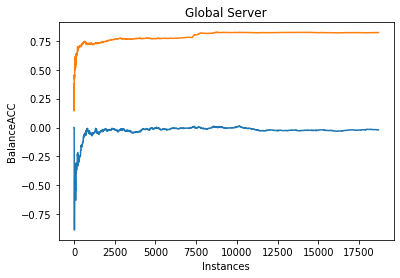

In [13]:
import matplotlib.pyplot as plt
plt.plot(stp_list)
plt.title('Global Server')
plt.xlabel('Instances')
plt.ylabel('BalanceACC')
plt.plot(bal_acc_list)

In [10]:
print(bal_acc_list)

[0.2916666666666667, 0.2727272727272727, 0.265625, 0.38095238095238093, 0.3557692307692308, 0.33870967741935487, 0.3263888888888889, 0.3780487804878049, 0.3641304347826087, 0.35294117647058826, 0.14460784313725492, 0.35294117647058826, 0.34375, 0.421875, 0.41419057377049184, 0.4551131928181109, 0.44859307359307365, 0.44299128101945007, 0.43812656641604014, 0.4338624338624339, 0.43009413067552604, 0.4267399267399268, 0.42373511904761907, 0.42102781706742104, 0.41857592093441154, 0.4388674388674389, 0.43585796387520526, 0.4330972058244786, 0.4305555555555556, 0.42820792439113053, 0.42603291316526615, 0.45121606334841635, 0.44919530823786147, 0.4473129610115912, 0.44555527254202754, 0.44391025641025644, 0.4423674151935022, 0.4559777571825765, 0.4687921727395412, 0.48087849650349657, 0.4784849128771781, 0.495544466227054, 0.4932795698924731, 0.491133254517818, 0.5018515470704411, 0.5120365912373616, 0.5095912934544315, 0.5072618865616878, 0.5050403225806451, 0.5029192818566632, 0.500892092

In [12]:
print(stp_list)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.4166666666666667, -0.8333333333333333, -0.8333333333333333, -0.8712121212121211, -0.8712121212121211, -0.8854166666666666, -0.8854166666666666, -0.8854166666666666, -0.8854166666666666, -0.8854166666666666, -0.8854166666666666, -0.8854166666666666, -0.8854166666666666, -0.8854166666666666, -0.8854166666666666, -0.8854166666666666, -0.8854166666666666, -0.8854166666666666, -0.8854166666666666, -0.8854166666666666, -0.8854166666666666, -0.46875, -0.46875, -0.46875, -0.46875, -0.46875, -0.46875, -0.46875, -0.46875, -0.46875, -0.46875, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.3125, -0.46875, -0.46875, -0.46875, -0.46875, -0.46875, -0.46875, -0.46875, -0.46875, -0.46875, -0.46875, -0